# NLOS with HHL

## 1. NLOS Test case generation

### Layout of testcase generation

1. Set SV at origin $(0, 0, 0)$
1. Based on $r_{min}$ and $r_{max}$, generate random HV position. `numpy.random.rand()` is used. 
1. Randomly create total of `num_points` points, each point's distance being farther away than $d_{min}$ but closer to each points than $d_{max}$.
1. Compute necessary quantities($\phi, \, \psi,\, \text{etc...}$)

In [363]:
import numpy as np

In [364]:


def estimate_x_norm(A, x_dir, b, eps=1e-18):
    """
    Ax=b에서 x의 방향(복소 가능)만 알고 있을 때,
    실수부 방향만 써서 ||x|| 추정. 반환형: numpy.float64 (float() 호출 안함)
    """
    A = np.asarray(A, dtype=np.complex128)
    b = np.asarray(b, dtype=np.complex128).reshape(-1)
    x_dir = np.asarray(x_dir, dtype=np.complex128).reshape(-1)

    m, n = A.shape
    if b.shape[0] != m:
        raise ValueError(f"b 길이 {b.shape[0]} != A 행 {m}")
    if x_dir.shape[0] != n:
        raise ValueError(f"x_dir 길이 {x_dir.shape[0]} != A 열 {n}")

    # 전역 위상 정렬 (sum 위상 기준)
    s = x_dir.sum()
    theta = -np.angle(s) if np.abs(s) > eps else 0.0
    x_aligned = x_dir * np.exp(1j * theta)

    # 실수부에서 방향 추출
    v = np.real(x_aligned).astype(np.float64)
    vn = np.linalg.norm(v)
    if vn < eps:
        raise ValueError("x_dir의 실수부가 너무 작음 (방향 추출 불가)")
    v /= vn

    Av = A @ v
    den = np.vdot(Av, Av)
    if np.abs(den) < eps:
        raise ValueError("분모가 너무 작음: Av ≈ 0")

    c_star = np.vdot(Av, b) / den   # 복소 가능
    # 노름만 필요 → 절댓값 (넘파이 스칼라 반환, float() 사용 안 함)
    norm_est = np.abs(c_star)       # dtype: numpy.float64

    return norm_est.item()  # 필요하면 .item()으로 파이썬 float로 변환


In [365]:
def dist(a: np.ndarray, b: np.ndarray):
    if a.shape != b.shape:
        raise ValueError("inconsistent point shape")
    return np.sqrt(np.sum((a - b) ** 2))

In [366]:
class NLOStestcase:
    """
    One randomized test case (NLOS geometry). Does not enforce NLOS by itself,
    just generates geometry.
    """
    def __init__(self: "NLOStestcase", sample_point_cnt: int, HV_r_min: float, HV_r_max: float, 
                 sample_r_min: float, sample_r_max: float, HV_orientation: float | None = None,
                 HV: tuple[float, float, float] | None = None, sample_points: tuple | list | None = None):
        
        if HV_r_min < 0 or HV_r_max < 0 or HV_r_min > HV_r_max:
            raise ValueError("HV radius restriction inappropriate")
        if HV_orientation is not None and (HV_orientation < 0 or HV_orientation > 2 * np.pi):
            raise ValueError("Inappropriate HV orientation")
        if sample_r_min < 0 or sample_r_max < 0 or sample_r_max < sample_r_min:
            raise ValueError("sample point distance restriction inappropriate")
        if sample_point_cnt <= 0:
            raise ValueError(f"Too small sample_point_cnt: {sample_point_cnt}")
        if (sample_points is not None and len(sample_points) != sample_point_cnt):
            raise ValueError("Sample point count/actual list mismatch")

        self.SV = np.zeros(3)

        self.sample_r_min = sample_r_min
        self.sample_r_max = sample_r_max
        
        if HV is None:
            self.HV = self._sample_point_in_shell(HV_r_min, HV_r_max)
            # print(f"HV position set randomly: {self.HV}")
        else:
            self.HV = HV
            # print(f"HV position set to given parameter: {self.HV}")
        
        if HV_orientation is None:
            self.HV_orientation = np.random.random() * 2 * np.pi
        else:
            self.HV_orientation = HV_orientation

        # if dist between HV and SV is greater than sample_r_max * 2, throw
        # print("SV: {0}, HV: {1}".format(self.HV, self.SV))
        if dist(self.HV, self.SV) > sample_r_max * 2.5:
            raise ValueError("sample_r_max is too small")
        
        # set the reflection sample points
        self.sample_point_cnt = sample_point_cnt
        if sample_points is None:
            points = set()
            while len(points) < self.sample_point_cnt:
                point = self._sample_point_in_shell(sample_r_min, sample_r_max)
                if sample_r_min < dist(point, self.HV) < sample_r_max:
                    points.add(tuple(point))
            self.sample_points = [np.array(x) for x in points]
        else:
            self.sample_points = sample_points

        # convert each point to NLOS-used spherical coordinates
        self.sample_spherical_points = []
        for x in self.sample_points:
            self.sample_spherical_points.append(np.array(self._to_NLOS_coordinates(x)))
        
        # add rho * c(time difference) to last array member
        self._add_rho()

        # sort by dist
        self.sample_spherical_points.sort(key=lambda x: x[0])

        # initialize
        self.A = np.zeros((3 * (self.sample_point_cnt - 1), (self.sample_point_cnt + 1)))
        self.b = np.zeros((3 * (self.sample_point_cnt - 1),))

        # todo: change this
        self.omega = self.HV_orientation

    def _random_direction_3d(self) -> np.ndarray:
        """
        Sample a random direction uniformly on the unit sphere S^2.
        """
        v = np.random.normal(size=3)
        norm = np.linalg.norm(v)
        if norm < 1e-12:
            # extremely unlikely; resample if it happens
            return self._random_direction_3d()
        return v / norm
    
    def _sample_point_in_shell(self, r_min: float, r_max: float) -> np.ndarray:
        """
        Sample a random 3D point whose distance from the origin is in [r_min, r_max].
        Direction is uniform; radius is uniform in [r_min, r_max] (not volume-uniform).
        """
        direction = self._random_direction_3d()
        r = r_min + (r_max - r_min) * np.random.rand()
        return r * direction
    
    def _cartesian_to_spherical(self, point: np.ndarray):
        r = dist(np.array([0, 0, 0]), point)
        rho = np.sqrt(np.sum(point[:2] ** 2))
        phi = np.arctan2(point[1], point[0])
        psi = np.arctan2(rho, point[2])
        return r, phi, psi
    
    def _to_NLOS_coordinates(self, point: np.ndarray):
        """returns d, v, theta, vartheta, phi, psi"""
        v, theta, var_theta = self._cartesian_to_spherical(point)
        v_p, phi_p, psi = self._cartesian_to_spherical(point - self.HV)
        
        phi = phi_p - self.HV_orientation
        if phi < 0: 
            phi += 2 * np.pi

        return (v + v_p, v, theta, var_theta, phi, psi, 0)
    
    def _add_rho(self):
        d_1 = min([x[0] for x in self.sample_spherical_points])
        for x in self.sample_spherical_points:
            x[-1] = x[0] - d_1

    def set_A(self, omega):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6
        
        # first point
        p1 = self.sample_spherical_points[0]

        # x direction matrix: assume point list is sorted
        for i, x in enumerate(self.sample_spherical_points[1:]):
            # - ( sin(var_theta) * cos(theta) + sin(psi) cos(phi+w) )
            self.A[i, 0] = -(np.sin(p1[3]) * np.cos(p1[2]) + np.sin(p1[5]) * np.cos(p1[4] + omega))

            # sin(var_theta) * cos(theta) + sin(psi) cos(phi+w)
            self.A[i, i + 1] = (np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + omega))
            
            # sin(psi_1) cos(phi_1 + omega) - sin(psi_p) cos(phi_p + omega)
            self.A[i, self.sample_point_cnt] = np.sin(p1[5]) * np.cos(p1[4] + omega) - np.sin(x[5]) * np.cos(x[4] + omega)
        
        # y direction matrix
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.A[(self.sample_point_cnt - 1) + i, 0] = -(np.sin(p1[3]) * np.sin(p1[2]) + np.sin(p1[5]) * np.sin(p1[4] + omega))

            self.A[(self.sample_point_cnt - 1) + i, i + 1] = (np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + omega))

            self.A[(self.sample_point_cnt - 1) + i, self.sample_point_cnt] = np.sin(p1[5]) * np.sin(p1[4] + omega) - np.sin(x[5]) * np.sin(x[4] + omega)
        
        # z direction matrix
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.A[(self.sample_point_cnt - 1) * 2 + i, 0] = -(np.cos(p1[3]) + np.cos(p1[5]))

            self.A[(self.sample_point_cnt - 1) * 2 + i, i + 1] = (np.cos(x[3]) + np.cos(x[5]))
            
            self.A[(self.sample_point_cnt - 1) * 2 + i, self.sample_point_cnt] = np.cos(p1[5]) - np.cos(x[5])

    def set_b(self, omega):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6

        # x direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[i] = x[6] * np.sin(x[5]) * np.cos(x[4] + omega)
        
        # y direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[(self.sample_point_cnt - 1) + i] = x[6] * np.sin(x[5]) * np.sin(x[4] + omega)
        
        # z direction
        for i, x in enumerate(self.sample_spherical_points[1:]):
            self.b[(self.sample_point_cnt - 1) * 2 + i] = x[6] * np.cos(x[5])

## 2. NLOS Preparation

### Method for obtaining $\omega$

$\omega$ is required to determine $\textbf{A}(\omega)$ and $\textbf{B}(\omega)$.

$\omega$ is determined by the equation $\text{null}(\textbf{A}(\omega)^\text{T})^\text{T} \textbf{B}(\omega)=0$.

Current implementation: Linear search

In [367]:
testcase = NLOStestcase(4, 10, 15, 8, 12)
testcase.set_A(testcase.omega)
testcase.set_b(testcase.omega)
print(testcase.HV)
print("-----------", testcase.A, "-------------", testcase.b, "------------", sep='\n')
classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]
print(classic_sol)
print([x[1] for x in testcase.sample_spherical_points])

[ 8.80080934 -2.22950641  7.93809187]
-----------
[[ 0.88270227 -1.24362453  0.          0.          0.03797558]
 [ 0.88270227  0.         -1.33607936  0.          0.04457217]
 [ 0.88270227  0.          0.         -0.46532414 -0.3108367 ]
 [ 0.24600049  0.03510806  0.          0.         -0.14952323]
 [ 0.24600049  0.         -0.41919955  0.          0.05150933]
 [ 0.24600049  0.          0.          1.21005139 -0.76058941]
 [-1.27525285  1.01176047  0.          0.          0.25444643]
 [-1.27525285  0.          0.86893339  0.          0.30932142]
 [-1.27525285  0.          0.          1.07080389  0.09626456]]
-------------
[-0.68733059 -1.61715709 -1.89403544  0.08834304 -0.11951475  2.17892808
  0.03378095 -0.01003082  0.61045382]
------------
[10.79904058  8.80527368  8.98690845 11.70100919 19.24358064]
[10.799040582048647, 8.805273682059642, 8.98690845137001, 11.701009189635547]


C:\Users\sungw\AppData\Local\Temp\ipykernel_47528\1762141599.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]


## 3. HHL Implementation

### Defs

In [368]:
import math
import numpy as np
import qiskit
from scipy.linalg import expm
from qiskit.circuit.library import StatePreparation, ExactReciprocalGate, phase_estimation
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.result import Result
from qiskit.circuit import IfElseOp, QuantumCircuit, QuantumRegister, ClassicalRegister, Gate
from qiskit.circuit.library import Initialize , UnitaryGate , QFTGate, ExactReciprocalGate, UCRYGate

from qiskit.quantum_info.operators.predicates import is_unitary_matrix

In [369]:
def progress_callback(**kwargs):
    pass_name = kwargs['pass_'].name()
    count = kwargs['count']
    # The DAG circuit is an internal representation that can be inspected
    dag = kwargs['dag'] 
    print(f"Pass {count}: {pass_name}, Operations: {dag.count_ops()}")


def hhl_fidelity(x_classic, probs_hhl):
    # Classical solution
    x = x_classic / np.linalg.norm(x_classic)

    # Rebuild complex vector from probabilities (up to global phase)
    # HHL gives only magnitudes; pick sign so inner product is maximized
    # Just treat as positive real for fidelity purposes

    probs_classical = np.abs(x) ** 2
    probs_classical = probs_classical / probs_classical.sum()

    # Normalize HHL probs just in case
    probs_hhl = probs_hhl / probs_hhl.sum()

    # Probability "fidelity" (Bhattacharyya coefficient)
    fidelity = float(np.sum(np.sqrt(probs_classical * probs_hhl)))
    # Numerical safety for arccos
    fidelity_clamped = max(min(fidelity, 1.0), -1.0)
    angle = float(np.rad2deg(np.arccos(fidelity_clamped)))

    return fidelity, angle

In [370]:
class CustomExactReciprocalGate(Gate):

    def __init__(
        self, num_state_qubits: int, scaling: float, neg_vals: bool = False, kappa: float | None = None, cutoff_ratio: float = 2.0, label: str = "1/x"
    ) -> None:
        super().__init__("CustomExactReciprocal", num_state_qubits + 1, [], label=label)

        self.scaling = scaling
        self.neg_vals = neg_vals
        self.kappa = kappa
        self.cutoff_ratio = cutoff_ratio
    
    def _f_lambda(self, lam: float) -> float:
        def f_original(lam):
            if math.isclose(self.scaling / lam, 1.0, abs_tol=1e-05):
                return 1.0
            elif self.scaling / lam < 1.0:
                return self.scaling / lam
            return 0.0

        if self.kappa is None:
            return f_original(lam)
        
        # original HHL paper for f(lambda)
        # if 1/kap_p < lambda < 1/kap: transition area
        # if lambda < 1/kap_p: too small lambda, don't rotate
        # if lamdba > 1/kap: good lambda, behave like original HHL
        kap = self.kappa
        kap_p = kap * self.cutoff_ratio

        # good area
        if lam >= 1 / kap:
            return f_original(lam)

        # bad area: not rotate at all
        if lam < 1 / kap_p:
            return 0.0
        
        # transition area
        t = (lam - 1 / kap_p) / (1 / kap - 1 / kap_p)
        return f_original(1 / kap) * math.sin(0.5 * math.pi * t)



    def _define(self):
        num_state_qubits = self.num_qubits - 1
        qr_state = QuantumRegister(num_state_qubits, "state")
        qr_flag = QuantumRegister(1, "flag")
        circuit = QuantumCircuit(qr_state, qr_flag)

        angles = [0.0]
        nl = 2 ** (num_state_qubits - 1) if self.neg_vals else 2**num_state_qubits

        # Angles to rotate by scaling / x, where x = i / nl
        for i in range(1, nl):
            lam = i / nl
            f = self._f_lambda(lam)
            if math.isclose(f, 1.0, abs_tol = 1e-5):
                angles.append(np.pi)
            elif f <= 0.0:
                angles.append(0.0)
            else:
                angles.append(2 * math.asin(f))

        circuit.append(UCRYGate(angles), [qr_flag[0]] + qr_state[: len(qr_state) - self.neg_vals])

        if self.neg_vals:
            circuit.append(
                UCRYGate([-theta for theta in angles]).control(),
                [qr_state[-1]] + [qr_flag[0]] + qr_state[:-1],
            )
            angles_neg = [0.0]
            for i in range(1, nl):
                lam_neg = -(1.0 - i / nl)
                lam = abs(lam_neg)
                f = self._f_lambda(lam)

                if math.isclose(f, 1.0, abs_tol = 1e-5):
                    angles_neg.append(-np.pi)
                elif f <= 0.0:
                    angles_neg.append(0.0)
                else:
                    angles_neg.append(-2 * math.asin(f))

            circuit.append(
                UCRYGate(angles_neg).control(), [qr_state[-1]] + [qr_flag[0]] + qr_state[:-1]
            )

        self.definition = circuit

In [371]:
class HHL:
    """class that implements HHL algorithm"""

    def __init__(self, A: np.typing.NDArray, b: np.typing.NDArray, state_dim: int = -1, tol=1e-05, lambda_min_eff=1e-01, force_cutoff=None):
        """A: operator matrix, b: matrix, n: number of qubits
        force_cutoff: 
            - True - Always use cutoff based on lambda_min_eff
            - None - use cutoff if eigval is  on lambda_min_eff
            - False - do not use cutoff at all times.
        """
        assert (len(A.shape) == 2 and len(b.shape) == 1), "Inconsistent dimension of A or b"
        assert (A.shape[0] == b.shape[0]), "shape of A does not match b"
        
        self.A = A.copy()
        self.b = b.copy()
        self.lambda_min_eff = lambda_min_eff

        if (self.A.shape[0] != self.A.shape[1] or not np.allclose(self.A, self.A.conj().T, atol=tol)):
            # if (self.A.shape[0] != self.A.shape[1]):
            #     print("A is not a square matrix")
            # else:
            #     print("A is not Hermitian")
            self.A = np.block([[np.zeros((self.A.shape[0], self.A.shape[0])), self.A],
                               [self.A.conj().T, np.zeros((self.A.shape[1], self.A.shape[1]))]])
            # print("A is evaluated as [[0, A], [AT, 0]]")
            # print("-----------------------------------")
            self.b = np.block([b, np.zeros(A.shape[1])])
        
        # pad A to be 2^n
        self.n_b = 0
        while (self.A.shape[0] > (1 << self.n_b)):
            self.n_b += 1
        
        if (self.A.shape[0] != (1 << self.n_b)):
            # print("A is not power of 2, pad to make A {0} * {0}".format((1 << self.n_b)))
            # print("-----------------------------------")
            pad = (1 << self.n_b) - self.A.shape[0]

            self.A = np.pad(self.A, ((0, pad), (0, pad)), "constant", constant_values=0)
            self.b = np.pad(self.b, (0, (1 << self.n_b) - self.b.shape[0]), "constant", constant_values=0)

        self.tol = tol
        self.dim = (1 << self.n_b)

        self.b_norm = 1

        if (not math.isclose(np.linalg.norm(self.b), 1, abs_tol=tol)):
            self.b_norm = np.linalg.norm(self.b)
            self.b = self.b.copy() / np.linalg.norm(self.b)
            # print(f"b is not normalized, normalized to b = {self.b} during init")
            # print("-----------------------------------")
        
        eigvals = np.linalg.eigvalsh(self.A)

        if force_cutoff or (force_cutoff is None and np.abs(eigvals).min() < lambda_min_eff):
            if not any(np.abs(eigvals) > lambda_min_eff):
                raise ValueError("lambda_min_eff is too big, all eigvals are smaller")
            
            lambda_min = np.abs(eigvals)[np.abs(eigvals) > lambda_min_eff].min()
            self.cutoff = True
            # print(f"chosen mode: {force_cutoff}\nCutoff enabled: lambda_min_eff - {lambda_min_eff}, min(eigvals) - {np.abs(eigvals).min()}")

        else:
            lambda_min = np.abs(eigvals).min()
            self.cutoff = False
        #     print(f"chosen mode: {force_cutoff}\nCutoff disabled")
        # print("-----------------------------------")

        # C for making C/λ < 1
        self.C = lambda_min * 0.9

        self.kappa = np.abs(eigvals).max() / lambda_min # characteristic number of matrix A
        # define t slightly smaller -> then if eigval is positive, < 0.45 and negative, > 0.55
        # if just pi / |lambda_max| -> 0.5 eigval errors
        self.t = np.pi / np.abs(eigvals).max() / 1.5 # calculate t

        self.phase_min_eff = lambda_min * self.t / (2 * np.pi)

        if (state_dim > 0):
            self.state_dim = state_dim
        else:
            if (self.kappa < 100):
                self.state_dim = int(np.log2(self.kappa)) + 6
            else:
                self.state_dim = 12

        self.U = expm(1j * self.t * self.A) # U = e^(iAt), then convert to unitarygate
    
    def _create_register(self):
        """call this to initially create registers, only once"""
        b_reg = QuantumRegister(self.n_b, 'sys')
        c_reg = QuantumRegister(self.state_dim, 'phase')
        aux_reg = QuantumRegister(1, 'aux')
        sign_reg = QuantumRegister(1, 'sign')
        classic_aux_reg = ClassicalRegister(1, 'classic_aux')
        result_reg = ClassicalRegister(self.n_b, 'classic_sys')
        return b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg


    def _prepare_state(self, circ: QuantumCircuit, b_reg: QuantumRegister):
        """add gate to mount b on registers"""
        # assert math.isclose(np.linalg.norm(self.b), 1, abs_tol=self.tol) # check if b is normalized
        temp_circ = QuantumCircuit(QuantumRegister(self.n_b, 'temp'))
        init_gate = StatePreparation(Statevector(self.b))
        temp_circ.append(init_gate, temp_circ.qubits)
        temp_gate = temp_circ.to_gate()
        temp_gate.label = "|b⟩ state preparation"
        circ.append(temp_gate, b_reg) # add gate for initalizing b
        circ.barrier() # separation from rest of the process

    def _assign_neg_sign(self, circ, c_reg, sign_reg):
        phase_le = list(reversed(c_reg)) # since qpe gives us big-endian, should reverse/little-endian expected in ExactReciprocalGate
        # if the most-significant bit(msb) is 1 -> phase > 1
        # therefore sign must be 1
        # if msb = 1 -> set sign to 1(controlled-not on sign_reg)
        circ.cx(phase_le[-1], sign_reg[0])
        

    def _controlled_rotation(self, circ: QuantumCircuit, c_reg: QuantumRegister, aux_reg: QuantumRegister, sign_reg: QuantumRegister):
        """add controlled rotation block to circuit"""
        # neg_vals = True: eigvals may be negative
        # if negative, ExactReciprocalGate expects sign qubit to be 1
        # and the phase to be (1 - phase)
        # switch to negative if sign = 1 in _assign_neg_sign

        # todo: choose the right kappa
        if self.cutoff:
            rot_gate = CustomExactReciprocalGate(
                num_state_qubits=self.state_dim + 1,
                scaling=self.C * self.t / (2 * np.pi),
                neg_vals=True,
                kappa=1 / self.phase_min_eff,
                cutoff_ratio=2.0
            )
        else:
            # rot_gate = CustomExactReciprocalGate(
            #     num_state_qubits=self.state_dim + 1,
            #     scaling=self.C * self.t / (2 * np.pi),
            #     neg_vals=True,
            #     kappa=None,
            # )
            rot_gate = ExactReciprocalGate(
                num_state_qubits=self.state_dim + 1, 
                scaling=self.C * self.t / (2 * np.pi), 
                neg_vals=True,
                label="Controlled-Y"
            )

        circ.append(rot_gate, [*sign_reg, *reversed(c_reg), *aux_reg])
    

    def _qpe(self, circ: QuantumCircuit, b_reg, c_reg, inverse=False):
        """add QPE/IQPE gate to the circuit"""
        qpe_circ = phase_estimation(self.state_dim, Operator(self.U).to_instruction())
        if (inverse):
            qpe_circ = qpe_circ.inverse()
        qpe_gate = qpe_circ.to_gate()
        qpe_gate.label = "QPE"
        if (inverse):
            qpe_gate.label="IQPE"
        circ.append(qpe_gate, [*c_reg, *b_reg]) # order may change


    def _measure(self, circ: QuantumCircuit, aux_reg: QuantumRegister, b_reg: QuantumRegister, classic_aux_reg: ClassicalRegister, result_reg: ClassicalRegister):
        """measure the quantum qubits and store in classic bits"""
        circ.measure(aux_reg, classic_aux_reg)
        circ.measure(b_reg, result_reg)

    def make_circuit(self):
        """function to create circuit. required to be executed before run and transpile"""
        b_reg, c_reg, aux_reg, sign_reg, classic_aux_reg, result_reg = self._create_register()


        circ = QuantumCircuit(aux_reg, c_reg, b_reg, sign_reg, result_reg, classic_aux_reg)
        self._prepare_state(circ, b_reg)
        self._qpe(circ, b_reg, c_reg, inverse=False)
        circ.barrier()
        # check if phase is negative
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._controlled_rotation(circ, c_reg, aux_reg, sign_reg)
        circ.barrier()
        self._assign_neg_sign(circ, c_reg, sign_reg)
        circ.barrier()
        self._qpe(circ, b_reg, c_reg, inverse=True)
        circ.barrier()
        self._measure(circ, aux_reg,  b_reg, classic_aux_reg, result_reg)

        return circ

    def transpile(self, circ, simulator=AerSimulator, show_progress=False):
        self.backend = simulator()
        if (show_progress):
            return transpile(circ, backend=self.backend, callback=progress_callback), circ
        return transpile(circ, backend=self.backend)
    
    def run(self, circ, shots=1) -> Result:
        try:
            return self.backend.run(circ, shots=shots).result()
        except AttributeError:
            raise AttributeError("Circuit is not Transpiled before running")
    
    def transpile_and_run(self, shots=1):
        transpiled_circ = self.transpile()
        return self.run(transpiled_circ, shots=shots).result()
    
    def analyze(self, result: Result, show_counts=False) -> tuple[float, np.ndarray]:
        count = result.get_counts()

        if (isinstance(count, dict)):
            if show_counts:
                print(count)
            success = {res: cnt for res, cnt in count.items() if res.split()[0] == '1'}
            # failure = {res: cnt for res, cnt in count.items() if res.split()[0] == '0'}
            tot = sum(success.values())
            success_rate = tot / sum(count.values())
            
            x = np.zeros((1 << self.n_b), dtype=float)
            for res, cnt in success.items():
                ind = int(res.split()[1], 2)
                x[ind] = cnt / tot

            return success_rate, x
        else:
            print(count)
            raise TypeError("result.get_counts() is not type dict[str, int]")
    
    def norm(self, success_rate):
        return np.sqrt(success_rate) / self.C * self.b_norm * 2

### HHL Test Example

In [372]:
    # [1, 2, 0],
    # [2, 1, 3],
    # [0, 3, 2]
A = np.array([
    [1, 2, 0, 1],
    [2, 1, 3, -1],
    [0, 3, 2, 4],
    [1, -1, 4, 4],
], dtype=float)
b = np.array([2, 5, -10, 3], dtype=float)

alg = HHL(A, b, lambda_min_eff=1e-1, force_cutoff=None)

print(np.linalg.eigvalsh(alg.A))

[-3.83476114  0.88196357  3.4106229   7.54217467]


In [373]:
circ = alg.make_circuit()
transpiled_circ = alg.transpile(circ, show_progress=False)
circ.draw(output="latex", filename="HHL.pdf")

MissingOptionalLibraryError: "The 'pdflatex' library is required to use 'LaTeX circuit drawing'.  You will likely need to install a full LaTeX distribution for your system."

In [374]:
# classic
try:
    x_classic = np.linalg.solve(alg.A, alg.b)
except np.linalg.LinAlgError as e:
    print(f"Failed to solve classically, {e.args}")
    x_classic = np.linalg.lstsq(alg.A, alg.b)[0] # first: singular value of A
except Exception as e:
    raise ValueError(f"Failed to solve: {e.args}")
print(x_classic)

for shots in [10**x for x in range(3, 7)]:
    print(f"shots: {shots}")
    result = alg.run(transpiled_circ, shots=shots)

    p, x = alg.analyze(result, show_counts=False)
    print(f"success rate: {p}\n{x}")
    fidelity, deg = hhl_fidelity(x_classic, x)
    print(f"Fidelity: {fidelity}, angle: {deg}")
    print("Classical Norm: {0}, HHL-based norm: {1}".format(np.linalg.norm(x_classic), math.sqrt(p) / alg.C) * 2)



print(x_classic ** 2 / np.linalg.norm(x_classic) ** 2)

[ 0.57043972 -0.21330336 -0.15850984  0.02641831]
shots: 1000
success rate: 0.062
[0.74193548 0.16129032 0.09677419 0.        ]
Fidelity: 0.9943913474216485, angle: 6.0711378316019164
Classical Norm: 0.6298595830750705, HHL-based norm: 0.3136914557731865Classical Norm: 0.6298595830750705, HHL-based norm: 0.3136914557731865
shots: 10000
success rate: 0.0605
[0.81818182 0.12231405 0.05950413 0.        ]
Fidelity: 0.9990285114438232, angle: 2.5257574368785156
Classical Norm: 0.6298595830750705, HHL-based norm: 0.30987356761549023Classical Norm: 0.6298595830750705, HHL-based norm: 0.30987356761549023
shots: 100000
success rate: 0.06167
[0.82763094 0.11139938 0.05886168 0.00210799]
Fidelity: 0.9999309514053718, angle: 0.6733138547959747
Classical Norm: 0.6298595830750705, HHL-based norm: 0.3128555179169199Classical Norm: 0.6298595830750705, HHL-based norm: 0.3128555179169199
shots: 1000000
success rate: 0.062157
[0.81677044 0.11699406 0.06382226 0.00241324]
Fidelity: 0.9999661677023286, ang

## 4. Apply HHL to NLOS

### 4.1 Solve using HHL

In [375]:
# linear_solver = HHL(testcase.A, testcase.b, lambda_min_eff=0.001, force_cutoff=True)
# circ = linear_solver.make_circuit()
# circ_trans = linear_solver.transpile(circ)

In [376]:
# n = testcase.sample_point_cnt
# result = linear_solver.run(circ_trans, 10**6)
# p, x = linear_solver.analyze(result)

# # return to the original state
# x = np.sqrt(x) * linear_solver.norm(p)
# print(linear_solver.norm(p))

# z = x[(n - 1) * 3:-(linear_solver.A.shape[0] - 3 * (n - 1) - (n + 1))]
# print(p, x, z, sep = '\n')
# print('\n')
# print(np.sqrt(np.average((classic_sol - z) / classic_sol) ** 2))
# print(np.acos(classic_sol @ z / np.linalg.norm(classic_sol) / np.linalg.norm(z)) * 360 / 2 / np.pi)
# print('\n')
# print(np.average(classic_sol / z))

### 4.2 Newly defined class 

In [377]:
from qiskit_aer.library import SaveState
from collections import defaultdict

In [378]:
def amp_embed_xdir_to_nb_qubits(x_dir: np.ndarray, n_b: int) -> np.ndarray:
    x_dir = np.asarray(x_dir, dtype=np.complex128).reshape(-1)
    P = 1 << n_b
    if x_dir.shape[0] > P:
        raise ValueError(f"x_dir 길이 {x_dir.shape[0]} > 2**n_b={P}, data 레지스터가 너무 작음")

    state = np.zeros(P, dtype=np.complex128)
    state[: x_dir.shape[0]] = x_dir
    # 노멀라이즈
    norm = np.linalg.norm(state)
    if norm < 1e-18:
        raise ValueError("임베딩한 상태 노름이 0에 가까움")
    state /= norm
    return state


In [379]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, Iterable, Optional, Tuple, List, Any

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate, StatePreparation
from qiskit.quantum_info import Statevector

from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from pyqsp.poly import PolyTaylorSeries


# ============================================================
# NumPy backend for QSVT + imag-extractor
# ============================================================

def _apply_rz_on_anc_inplace(psi: np.ndarray, N: int, phi: float):
    """
    Apply qiskit Rz(theta) on anc with theta = -2*phi.
    Rz(-2phi) = diag(e^{+i phi}, e^{-i phi}) on anc |0>,|1>.
    anc is MSB, so anc=0 indices [0:N), anc=1 indices [N:2N).
    """
    psi[:N] *= np.exp(1j * phi)
    psi[N:] *= np.exp(-1j * phi)


def _apply_z_on_anc_inplace(psi: np.ndarray, N: int):
    """Apply Z on anc (MSB): anc=1 half flips sign."""
    psi[N:] *= -1.0


def _apply_W_inplace(psi: np.ndarray, U_block: np.ndarray, N: int, tmp: np.ndarray):
    """
    W = Z_anc * U_block  (since in circuit: apply U_block then Z)
    """
    tmp[:] = U_block @ psi
    psi[:] = tmp
    _apply_z_on_anc_inplace(psi, N)


def _apply_W_dagger_inplace(psi: np.ndarray, U_block_dag: np.ndarray, N: int, tmp: np.ndarray):
    """
    W† = (Z U)† = U† Z
    """
    _apply_z_on_anc_inplace(psi, N)
    tmp[:] = U_block_dag @ psi
    psi[:] = tmp


def apply_qsvt_to_state_numpy(
    psi: np.ndarray,
    U_block: np.ndarray,
    phases: np.ndarray,
) -> np.ndarray:
    """
    Apply QSVT unitary (same as build_qsvt_from_phases) directly to statevector.
    """
    psi = np.asarray(psi, dtype=np.complex128).copy()
    phases = np.asarray(phases, dtype=float).reshape(-1)

    dimU = U_block.shape[0]
    assert U_block.shape == (dimU, dimU)
    assert dimU % 2 == 0
    N = dimU // 2

    tmp = np.zeros_like(psi)

    for phi in phases[:-1]:
        _apply_rz_on_anc_inplace(psi, N, float(phi))
        _apply_W_inplace(psi, U_block, N, tmp)

    _apply_rz_on_anc_inplace(psi, N, float(phases[-1]))
    return psi


def apply_qsvt_dagger_to_state_numpy(
    psi: np.ndarray,
    U_block: np.ndarray,
    phases: np.ndarray,
) -> np.ndarray:
    """
    Apply U_qsvt† to a statevector.
    """
    psi = np.asarray(psi, dtype=np.complex128).copy()
    phases = np.asarray(phases, dtype=float).reshape(-1)

    dimU = U_block.shape[0]
    assert dimU % 2 == 0
    N = dimU // 2

    U_block_dag = U_block.conj().T
    tmp = np.zeros_like(psi)

    _apply_rz_on_anc_inplace(psi, N, float(-phases[-1]))

    for phi in phases[-2::-1]:
        _apply_W_dagger_inplace(psi, U_block_dag, N, tmp)
        _apply_rz_on_anc_inplace(psi, N, float(-phi))

    return psi


def imag_extractor_numpy(
    bHp: np.ndarray,
    U_block: np.ndarray,
    phases: np.ndarray,
) -> Tuple[np.ndarray, float, Optional[np.ndarray]]:
    """
    Numpy equivalent of odd (U - U†)/2 extractor.
    Start: anc=0 ⊗ |bHp>.
    Return:
      y_vec      : anc=0 branch after (U - U†)/2
      p_succ     : ||y_vec||^2
      psi_success: normalized success-branch state (system only), or None if p_succ≈0
    """
    bHp = np.asarray(bHp, dtype=np.complex128).reshape(-1)
    bHp = bHp / (np.linalg.norm(bHp) + 1e-18)

    dimU = U_block.shape[0]
    assert dimU % 2 == 0
    N = dimU // 2
    assert bHp.shape[0] == N, f"bHp len={len(bHp)} but expected N={N}"

    psi = np.zeros((dimU,), dtype=np.complex128)
    psi[:N] = bHp  # anc=0

    upsi = apply_qsvt_to_state_numpy(psi, U_block, phases)
    upsid = apply_qsvt_dagger_to_state_numpy(psi, U_block, phases)

    y_total = 0.5 * (upsi - upsid)
    y_vec = y_total[:N].copy()

    p_succ = float(np.vdot(y_vec, y_vec).real)
    psi_success = None
    if p_succ > 1e-18:
        psi_success = y_vec / np.sqrt(p_succ)

    return y_vec, p_succ, psi_success


# ============================================================
# A construction / embedding / padding
# ============================================================

def make_A7_strict(
    P: int,
    a1_cos: float,
    a_diag_cos: np.ndarray,
    a_tail_cos: np.ndarray,
    a1_sin: float,
    a_diag_sin: np.ndarray,
    a_tail_sin: np.ndarray,
) -> np.ndarray:
    """
    (필요하면 쓰는) 특정 구조의 A 행렬 생성.
    """
    a_diag_cos = np.asarray(a_diag_cos, dtype=float).reshape(-1)
    a_tail_cos = np.asarray(a_tail_cos, dtype=float).reshape(-1)
    a_diag_sin = np.asarray(a_diag_sin, dtype=float).reshape(-1)
    a_tail_sin = np.asarray(a_tail_sin, dtype=float).reshape(-1)

    assert a_diag_cos.shape[0] == P - 1
    assert a_tail_cos.shape[0] == P - 1
    assert a_diag_sin.shape[0] == P - 1
    assert a_tail_sin.shape[0] == P - 1

    A_cos = np.zeros((P - 1, P + 1), dtype=float)
    A_sin = np.zeros((P - 1, P + 1), dtype=float)

    for i in range(P - 1):
        A_cos[i, 0] = a1_cos
        A_sin[i, 0] = a1_sin

        A_cos[i, i + 1] = -a_diag_cos[i]
        A_sin[i, i + 1] = -a_diag_sin[i]

        A_cos[i, P] = a_tail_cos[i]
        A_sin[i, P] = a_tail_sin[i]

    return np.vstack([A_cos, A_sin]).astype(np.complex128)


def hermitian_embedding(A: np.ndarray) -> np.ndarray:
    """
    H = [ 0  A
          A† 0 ]
    """
    A = np.asarray(A, dtype=np.complex128)
    m, n = A.shape
    Zm = np.zeros((m, m), dtype=np.complex128)
    Zn = np.zeros((n, n), dtype=np.complex128)
    return np.block([[Zm, A], [A.conj().T, Zn]])


def make_consistent_b(A: np.ndarray, rng: np.random.Generator):
    A = np.asarray(A, dtype=np.complex128)
    x_true = rng.normal(size=A.shape[1]) + 0j
    b = A @ x_true
    return b, x_true


def embed_linear_system(A: np.ndarray, b: np.ndarray):
    """
    (A, b) → (H, bH) 로 올려주는 부분.
    """
    A = np.asarray(A, dtype=np.complex128)
    b = np.asarray(b, dtype=np.complex128).reshape(-1)
    m, n = A.shape
    H = hermitian_embedding(A)
    bH = np.concatenate([b, np.zeros(n, dtype=np.complex128)], axis=0)
    return H, bH


def next_pow2(n: int) -> int:
    return 1 << (n - 1).bit_length()


def pad_to_pow2_hermitian(M: np.ndarray, pad_diag: float = 1.0) -> np.ndarray:
    """
    Hermitian 행렬을 2^k 크기로 패딩, 패딩된 부분은 pad_diag * I.
    """
    M = np.asarray(M, dtype=np.complex128)
    n = M.shape[0]
    N = next_pow2(n)
    if N == n:
        return M
    Mp = np.zeros((N, N), dtype=np.complex128)
    Mp[:n, :n] = M
    Mp[n:, n:] = pad_diag * np.eye(N - n, dtype=np.complex128)
    return Mp


def pad_vec_to_len(v: np.ndarray, N: int) -> np.ndarray:
    v = np.asarray(v, dtype=np.complex128).reshape(-1)
    out = np.zeros((N,), dtype=np.complex128)
    out[:len(v)] = v
    return out


# ============================================================
# Halmos block-encoding with forced alpha
# ============================================================

def halmos_block_encode_hermitian_forced_alpha(H: np.ndarray, alpha: float):
    """
    Hermitian H를 Halmos dilation으로 block-encoding 유니터리 U로 올림.
    top-left block ≈ H/alpha.
    """
    H = np.asarray(H, dtype=np.complex128)
    H = (H + H.conj().T) / 2
    N = H.shape[0]
    Atil = H / alpha

    w, V = np.linalg.eigh(Atil)
    w = np.clip(w, -1.0, 1.0)
    s = np.sqrt(np.clip(1.0 - w * w, 0.0, None))
    B = V @ np.diag(s) @ V.conj().T

    U = np.block([[Atil, B],
                  [B,   -Atil]])

    unit_err = np.linalg.norm(U.conj().T @ U - np.eye(2 * N))
    tl_err = np.linalg.norm(U[:N, :N] - Atil)
    return U, float(unit_err), float(tl_err)


# ============================================================
# target g(x): regularized inverse + odd enforcement
# ============================================================

def _raw_reginv(x: np.ndarray, mu: float) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    return x / (x * x + mu * mu)


def target_regularized_inverse_fixedscale_safe(
    x: np.ndarray,
    mu: float,
    max_scale: float,
    L: float = 0.9,
    safety_grid: int = 4096,
) -> np.ndarray:
    """
    g(x) = c * x/(x^2+mu^2), with global scale c chosen so that
    max_{|x| ≤ max_scale} |g(x)| ≤ L.
    홀함수(odd) 강제를 위해 g(x)→(g(x)-g(-x))/2 과정 수행.
    """
    x = np.asarray(x, dtype=float)

    if max_scale >= mu:
        max_abs = 1.0 / (2.0 * mu)
    else:
        max_abs = max_scale / (max_scale * max_scale + mu * mu)

    c = (L / max_abs) if max_abs > 0 else 1.0
    y = c * _raw_reginv(x, mu)

    # 홀함수 강제: (g(x) - g(-x))/2
    y = 0.5 * (y - (c * _raw_reginv(-x, mu)))

    # safety check on dense grid
    xs = np.linspace(-max_scale, max_scale, safety_grid)
    ys = c * _raw_reginv(xs, mu)
    ys = 0.5 * (ys - (c * _raw_reginv(-xs, mu)))
    m = float(np.max(np.abs(ys)))
    if m > L * (1.0 + 1e-6):
        c2 = (L / m)
        y *= c2
    return y


def make_g(mu: float, max_scale: float, L: float) -> Callable[[np.ndarray], np.ndarray]:
    def g(x):
        return target_regularized_inverse_fixedscale_safe(
            x, mu=mu, max_scale=max_scale, L=L
        )
    return g


# ============================================================
# classical apply f(H)b (for tuning & reference)
# ============================================================

def classical_apply_fHb(Hp: np.ndarray, bHp: np.ndarray, alpha: float, g_func) -> np.ndarray:
    Hp = np.asarray(Hp, dtype=np.complex128)
    bHp = np.asarray(bHp, dtype=np.complex128).reshape(-1)

    w, V = np.linalg.eigh(Hp)
    lam_tilde = (w / alpha).real
    g_vals = g_func(lam_tilde)  # real
    y = V @ (g_vals * (V.conj().T @ bHp))
    return y


# ============================================================
# QSP phase synthesis wrapper
# ============================================================

@dataclass
class QSPResult:
    ok: bool
    reason: str
    phases: Optional[np.ndarray] = None
    g: Optional[Callable[[np.ndarray], np.ndarray]] = None
    poly: Optional[Any] = None
    domain_err: Optional[float] = None
    poly_max: Optional[float] = None


def try_synthesize_qsp_phases(
    mu: float,
    degree: int,
    max_scale: float,
    L: float,
    poly_max_tol: float = 1.02,
    domain_err_tol: float = 5e-3,
    grid: int = 1201,
) -> QSPResult:
    g = make_g(mu=mu, max_scale=max_scale, L=L)

    try:
        poly = PolyTaylorSeries().taylor_series(
            func=g,
            degree=degree,
            max_scale=max_scale,
            chebyshev_basis=True,
        )
    except Exception as e:
        return QSPResult(False, f"PolyTaylorSeries failed: {type(e).__name__}: {e}")

    xs = np.linspace(-max_scale, max_scale, grid)
    gx = g(xs)
    px = poly(xs)
    domain_err = float(np.max(np.abs(gx - px)))
    poly_max = float(np.max(np.abs(px)))

    if (not np.isfinite(domain_err)) or (not np.isfinite(poly_max)):
        return QSPResult(
            False,
            "non-finite domain_err/poly_max",
            g=g,
            poly=poly,
            domain_err=domain_err,
            poly_max=poly_max,
        )

    if poly_max > poly_max_tol:
        return QSPResult(
            False,
            f"poly_max too large ({poly_max:.3g} > {poly_max_tol})",
            g=g,
            poly=poly,
            domain_err=domain_err,
            poly_max=poly_max,
        )

    if domain_err > domain_err_tol:
        return QSPResult(
            False,
            f"domain_err too large ({domain_err:.3g} > {domain_err_tol})",
            g=g,
            poly=poly,
            domain_err=domain_err,
            poly_max=poly_max,
        )

    try:
        phases, _, _ = QuantumSignalProcessingPhases(
            poly,
            method="sym_qsp",
            chebyshev_basis=True,
        )
    except Exception as e:
        return QSPResult(
            False,
            f"sym_qsp failed: {type(e).__name__}: {e}",
            g=g,
            poly=poly,
            domain_err=domain_err,
            poly_max=poly_max,
        )

    phases = np.array(phases, dtype=float).reshape(-1)
    return QSPResult(
        True,
        "ok",
        phases=phases,
        g=g,
        poly=poly,
        domain_err=domain_err,
        poly_max=poly_max,
    )


# ============================================================
# QSVT circuit (gate backend)
# ============================================================

def build_qubiterate(U_block: np.ndarray, anc: int) -> QuantumCircuit:
    dim = U_block.shape[0]
    n_qubits = int(np.log2(dim))
    assert 2 ** n_qubits == dim, f"U_block dim={dim} not power-of-2"

    qc = QuantumCircuit(n_qubits)
    qc.append(UnitaryGate(U_block, label="U_A", check_input=False), list(range(n_qubits)))
    qc.z(anc)
    return qc


def build_qsvt_from_phases(U_block: np.ndarray, phases: np.ndarray, anc: int) -> QuantumCircuit:
    W_gate = build_qubiterate(U_block, anc).to_gate(label="W")
    n = int(np.log2(U_block.shape[0]))
    qc = QuantumCircuit(n)

    for phi in phases[:-1]:
        qc.rz(-2.0 * float(phi), anc)
        qc.append(W_gate, list(range(n)))
    qc.rz(-2.0 * float(phases[-1]), anc)
    return qc


def postselect_bits(sv: np.ndarray, n_qubits: int, fixed: dict[int, int]):
    """
    Statevector sv 에서, 고정된 큐빗(fixed)에 맞는 성분만 남기고
    나머지 큐빗에 대한 상태를 반환.
    """
    keep = [q for q in range(n_qubits) if q not in fixed]
    out = np.zeros((2 ** len(keep),), dtype=np.complex128)

    for idx, amp in enumerate(sv):
        ok = True
        for q, v in fixed.items():
            if ((idx >> q) & 1) != v:
                ok = False
                break
        if not ok:
            continue

        j = 0
        for k, q in enumerate(keep):
            j |= (((idx >> q) & 1) << k)
        out[j] = amp

    p = float(np.vdot(out, out).real)
    return out, p, keep


def build_imag_extractor(U_circ: QuantumCircuit, sys_state: np.ndarray, sys_qubits: List[int]):
    """
    ctrl qubit 추가해서 (U - U†)/2 구현.
    """
    nq = U_circ.num_qubits
    ctrl = nq
    qc = QuantumCircuit(nq + 1)

    b = np.asarray(sys_state, dtype=np.complex128).reshape(-1)
    b = b / (np.linalg.norm(b) + 1e-18)
    qc.append(StatePreparation(b), sys_qubits)

    Ug = U_circ.to_gate(label="Uqsvt")
    Ugd = U_circ.inverse().to_gate(label="Uqsvt†")

    qc.h(ctrl)

    qc.x(ctrl)
    qc.append(Ug.control(1), [ctrl] + list(range(nq)))
    qc.x(ctrl)

    qc.append(Ugd.control(1), [ctrl] + list(range(nq)))

    qc.h(ctrl)
    return qc, ctrl


def report_gate_stats(qc: QuantumCircuit, basis_gates=None, opt: int = 1):
    if basis_gates is None:
        tqc = transpile(qc, optimization_level=opt)
    else:
        tqc = transpile(qc, basis_gates=basis_gates, optimization_level=opt)
    return {
        "depth": tqc.depth(),
        "count_ops": dict(tqc.count_ops()),
        "num_qubits": tqc.num_qubits,
    }


def debug_embedding(A: np.ndarray, H: np.ndarray):
    A = np.asarray(A, dtype=np.complex128)
    H = np.asarray(H, dtype=np.complex128)
    s = np.linalg.svd(A, compute_uv=False)
    w = np.linalg.eigvalsh((H + H.conj().T) / 2)
    w_sorted = np.sort(w)

    print(">>> Embedding debug")
    print("singular values σ(A):", np.round(s, 6))
    print("eigenvalues λ(H):", np.round(w_sorted, 6))
    print("min/max |λ(H)|:", float(np.min(np.abs(w_sorted))), float(np.max(np.abs(w_sorted))))
    print()


# ============================================================
# Candidate structure + classical tuning
# ============================================================

@dataclass
class Candidate:
    score: float
    objective: str
    max_scale: float
    mu: float
    pad_diag: float
    alpha: float
    rel_err_class: float
    resid_class: float


def tune_params_classical(
    A: np.ndarray,
    b: np.ndarray,
    x_ls: np.ndarray,
    max_scale_grid: Iterable[float],
    mu_grid: Iterable[float],
    pad_diag_grid: Iterable[float],
    L: float = 0.9,
    objective: str = "resid",
    top_k: int = 8,
    verbose: bool = True,
) -> Tuple[List[Candidate], np.ndarray, np.ndarray, np.ndarray]:
    """
    여러 (pad_diag, max_scale, mu) 조합에 대해
    classical f(H_p)bHp 를 계산해보고
    resid / rel_err 기준으로 score를 매겨 상위 top_k 후보를 반환.
    """
    m, n = A.shape
    H, bH = embed_linear_system(A, b)
    H = (H + H.conj().T) / 2

    cands: List[Candidate] = []

    for pad_diag in pad_diag_grid:
        Hp = pad_to_pow2_hermitian(H, pad_diag=pad_diag)
        N = Hp.shape[0]
        bHp = pad_vec_to_len(bH, N)
        bHp = bHp / (np.linalg.norm(bHp) + 1e-18)

        w = np.linalg.eigvalsh(Hp)
        rho = float(np.max(np.abs(w))) + 1e-18

        y_target = np.concatenate([np.zeros(m, dtype=np.complex128), x_ls], axis=0)
        y_target = pad_vec_to_len(y_target, N)

        for max_scale in max_scale_grid:
            alpha = rho / max_scale

            for mu in mu_grid:
                g = make_g(mu=mu, max_scale=max_scale, L=L)
                y_class = classical_apply_fHb(Hp, bHp, alpha, g)

                sc = (np.vdot(y_class, y_target) /
                      (np.vdot(y_class, y_class) + 1e-18))
                y_hat = sc * y_class
                x_hat = y_hat[m:m + n]

                rel_err = float(np.linalg.norm(x_hat - x_ls) /
                                (np.linalg.norm(x_ls) + 1e-18))
                resid = float(np.linalg.norm(A @ x_hat - b) /
                              (np.linalg.norm(b) + 1e-18))

                if objective == "resid":
                    score = resid
                elif objective == "rel_err":
                    score = rel_err
                else:
                    score = resid + 0.5 * rel_err

                cand = Candidate(
                    score=float(score),
                    objective=objective,
                    max_scale=float(max_scale),
                    mu=float(mu),
                    pad_diag=float(pad_diag),
                    alpha=float(alpha),
                    rel_err_class=float(rel_err),
                    resid_class=float(resid),
                )
                cands.append(cand)

    cands.sort(key=lambda c: c.score)
    if verbose:
        print(">>> Classical tuning done, best scores:")
        for i, c in enumerate(cands[:min(top_k, len(cands))]):
            print(f"  [{i}] score={c.score:.3e}, pad={c.pad_diag}, "
                  f"max_scale={c.max_scale}, mu={c.mu}, "
                  f"rel_err={c.rel_err_class:.3e}, resid={c.resid_class:.3e}")
        print()

    return cands[:top_k], H, bH, x_ls


# ============================================================
# QSVT backends: numpy / gate
# ============================================================

def qsvt_apply_numpy(
    U_block: np.ndarray,
    phases: np.ndarray,
    bHp: np.ndarray,
    anc: int,
):
    """
    Numpy backend: U_block 를 직접 곱해서 QSVT + odd extractor를 구현.
    """
    y_vec, p_succ, psi_success = imag_extractor_numpy(
        bHp=bHp,
        U_block=U_block,
        phases=phases,
    )
    return y_vec, p_succ, psi_success


def qsvt_apply_gate(
    U_block: np.ndarray,
    phases: np.ndarray,
    anc: int,
    bHp: np.ndarray,
    sys_qubits: List[int],
):
    """
    Gate backend: Qiskit 회로로 QSVT 구현 + imag-extractor.
    """
    qsvt = build_qsvt_from_phases(U_block, phases, anc)
    qc_im, ctrl = build_imag_extractor(qsvt, bHp, sys_qubits)

    sv_full = Statevector.from_instruction(qc_im).data
    y_vec, p_succ, _ = postselect_bits(
        sv_full,
        qc_im.num_qubits,
        fixed={ctrl: 1, anc: 0},
    )

    psi_success = None
    if p_succ > 1e-18:
        psi_success = y_vec / np.sqrt(p_succ)

    return y_vec, p_succ, psi_success, qc_im, sv_full


def run_qsvt(
    U_block: np.ndarray,
    phases: np.ndarray,
    bHp: np.ndarray,
    anc: int,
    sys_qubits: List[int],
    mode: str = "gate",
):
    """
    mode="gate"  → Qiskit 회로 실행
    mode="numpy" → numpy unitary 곱으로 QSVT 시뮬레이션
    """
    if mode == "gate":
        y_vec, p_succ, psi_success, qc, sv_full = qsvt_apply_gate(
            U_block, phases, anc, bHp, sys_qubits
        )
        return {
            "y": y_vec,
            "p_succ": p_succ,
            "psi_success": psi_success,
            "qc": qc,
            "statevec_full": sv_full,
            "mode": "gate",
        }
    elif mode == "numpy":
        y_vec, p_succ, psi_success = qsvt_apply_numpy(
            U_block, phases, bHp, anc
        )
        return {
            "y": y_vec,
            "p_succ": p_succ,
            "psi_success": psi_success,
            "qc": None,
            "statevec_full": None,
            "mode": "numpy",
        }
    else:
        raise ValueError("mode must be 'gate' or 'numpy'")


# ============================================================
# Shot sampling + state reconstruction helpers
# ============================================================

def sample_shots_from_state(
    psi: np.ndarray,
    num_shots: int,
    rng: Optional[np.random.Generator] = None,
) -> dict:
    """
    정규화 여부와 상관없이 상태벡터 psi에서 계산기저 측정 샷 샘플링.
    """
    psi = np.asarray(psi, dtype=np.complex128).reshape(-1)
    norm = np.linalg.norm(psi)
    if norm <= 1e-18:
        raise ValueError("State has near-zero norm.")
    psi = psi / norm

    dim = psi.shape[0]
    num_qubits = int(np.log2(dim))
    if 2 ** num_qubits != dim:
        raise ValueError("psi length is not a power of 2.")

    probs = np.abs(psi) ** 2
    probs = probs / probs.sum()

    if rng is None:
        rng = np.random.default_rng()

    idxs = rng.choice(dim, size=num_shots, p=probs)
    counts: dict[str, int] = {}
    for idx in idxs:
        bitstr = format(idx, f"0{num_qubits}b")
        counts[bitstr] = counts.get(bitstr, 0) + 1
    return counts


def normalize_counts(counts: dict, num_qubits: int) -> np.ndarray:
    """
    샷 카운트 → 확률 벡터.
    """
    dim = 2 ** num_qubits
    probs = np.zeros(dim, dtype=float)

    total_shots = sum(counts.values())
    if total_shots == 0:
        raise ValueError("총 샷 수가 0입니다.")

    for bitstr, c in counts.items():
        if len(bitstr) != num_qubits:
            raise ValueError(f"비트스트링 길이가 num_qubits와 다름: {bitstr}")
        idx = int(bitstr, 2)
        probs[idx] += c

    probs /= total_shots
    return probs


def reconstruct_state_from_counts(
    counts: dict,
    num_qubits: int,
    assume_real_nonnegative: bool = True,
):
    """
    샷 카운트 → 확률 → (가정 하에) 상태벡터 복원.

    assume_real_nonnegative=True:
      ψ_i 가 실수이면서 0 이상이라고 가정하고 |ψ_i| ≈ sqrt(p_i).
    """
    probs = normalize_counts(counts, num_qubits)
    amps_abs = np.sqrt(probs)

    if assume_real_nonnegative:
        psi_est = amps_abs.astype(np.complex128)
    else:
        psi_est = amps_abs.astype(np.complex128)

    norm = np.linalg.norm(psi_est)
    if norm > 0:
        psi_est /= norm

    return probs, amps_abs, psi_est


def qsvt_state_to_shots_and_reconstruct(psi, num_shots=10_000, seed=None):
    """
    psi: 최종 상태벡터 (numpy 1D complex)
    num_shots: 샷 수
    return: counts, probs_est, amps_abs_est, psi_est
    """
    psi = np.asarray(psi, dtype=np.complex128)
    N = psi.shape[0]

    # 이상적인 확률
    probs_true = np.abs(psi) ** 2
    probs_true = probs_true / (probs_true.sum() + 1e-18)

    # 샷 샘플링
    rng = np.random.default_rng(seed)
    counts = rng.multinomial(num_shots, probs_true)

    # 샷으로부터 추정한 확률
    probs_est = counts / num_shots

    # 확률에서 절댓값 추정 (위상/부호는 알 수 없음)
    amps_abs_est = np.sqrt(probs_est)

    # 전체 상태 추정 (모든 성분을 실수 양수로 두고 global phase 1로 고정)
    norm = np.linalg.norm(amps_abs_est)
    if norm < 1e-18:
        psi_est = amps_abs_est.astype(np.complex128)
    else:
        psi_est = (amps_abs_est / norm).astype(np.complex128)

    return counts, probs_est, amps_abs_est, psi_est


# ============================================================
# Main QSVT pipeline: from A,b to x_hat
# ============================================================

def qsvt_solve_from_Ab(
    A: np.ndarray,
    b: np.ndarray,
    *,
    degree=120,
    max_scale_grid=(0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
    mu_grid=(0.02, 0.04, 0.06, 0.08, 0.12),
    pad_diag_grid=(1.0, 2.0),
    L=0.6,
    objective="resid",
    top_k=8,
    poly_max_tol=1.5,
    domain_err_tol=2e-1,
    spec_err_tol=2e-1,
    mode="numpy",      # "numpy" or "gate"
):
    """
    A, b 로부터 QSVT 기반 regularized inverse를 통해 x_hat을 구하는 파이프라인.
    + 성공확률, psi_success 등도 같이 반환.
    """
    A = np.asarray(A, dtype=np.complex128)
    b = np.asarray(b, dtype=np.complex128).reshape(-1)
    m, n = A.shape
    assert b.shape[0] == m

    print(">>> [NLOS] A,b injected")
    print("A shape:", A.shape, "b shape:", b.shape)
    s = np.linalg.svd(A, compute_uv=False)
    print("singular values σ(A):", np.round(s, 4))
    print("cond(A) =", float(s[0] / (s[-1] + 1e-18)))
    print()

    # classical LS reference
    x_ls = np.linalg.lstsq(A, b, rcond=None)[0]

    # 1) Hermitian embedding
    H, bH = embed_linear_system(A, b)
    H = (H + H.conj().T) / 2
    debug_embedding(A, H)

    # 2) Classical tuning
    print(">>> Tuning (classical) start")
    top_cands, H, bH, x_ls = tune_params_classical(
        A=A, b=b, x_ls=x_ls,
        max_scale_grid=max_scale_grid,
        mu_grid=mu_grid,
        pad_diag_grid=pad_diag_grid,
        L=L,
        objective=objective,
        top_k=top_k,
        verbose=True,
    )

    # 3) QSP feasibility check on top candidates
    feasible = None
    feasible_qsp: Optional[QSPResult] = None
    feasible_spec_err: Optional[float] = None

    for i, c in enumerate(top_cands):
        print(f">>> QSP try cand[{i}] pad={c.pad_diag}, "
              f"max_scale={c.max_scale}, mu={c.mu}, degree={degree}")

        qsp_res = try_synthesize_qsp_phases(
            mu=c.mu,
            degree=degree,
            max_scale=c.max_scale,
            L=L,
            poly_max_tol=poly_max_tol,
            domain_err_tol=domain_err_tol,
        )
        if not qsp_res.ok:
            print("   -> FAIL:", qsp_res.reason)
            if qsp_res.poly_max is not None or qsp_res.domain_err is not None:
                print(f"      poly_max={qsp_res.poly_max} domain_err={qsp_res.domain_err}")
            print()
            continue

        Hp = pad_to_pow2_hermitian(H, pad_diag=c.pad_diag)
        w_Hp = np.linalg.eigvalsh(Hp)
        lam_tilde = (w_Hp / c.alpha).real

        gx = qsp_res.g(lam_tilde)
        px = qsp_res.poly(lam_tilde)
        spec_err = float(np.max(np.abs(gx - px)))

        print(f"   ok: domain_err={qsp_res.domain_err:.3e}, "
              f"poly_max={qsp_res.poly_max:.6f}, spec_err={spec_err:.3e}")
        if spec_err > spec_err_tol:
            print(f"   -> SKIP: spec_err too large ({spec_err:.3g} > {spec_err_tol})\n")
            continue

        feasible = c
        feasible_qsp = qsp_res
        feasible_spec_err = spec_err
        print("   -> SELECTED\n")
        break

    if feasible is None or feasible_qsp is None:
        raise RuntimeError("No feasible candidate. "
                           "Try adjusting mu_grid, L, max_scale, or degree.")

    # 4) Build Hp/bHp for chosen candidate
    pad_diag = feasible.pad_diag
    alpha = feasible.alpha
    Hp = pad_to_pow2_hermitian(H, pad_diag=pad_diag)
    N = Hp.shape[0]
    bHp = pad_vec_to_len(bH, N)
    bHp = bHp / (np.linalg.norm(bHp) + 1e-18)

    print(">>> Selected params")
    print(f"pad_diag={pad_diag}, max_scale={feasible.max_scale}, "
          f"mu={feasible.mu}, alpha={alpha:.6e}")
    print(f"QSP: domain_err={feasible_qsp.domain_err:.3e}, "
          f"poly_max={feasible_qsp.poly_max:.6f}, "
          f"spec_err={feasible_spec_err:.3e}")
    print()

    # 5) Halmos block encoding
    U_block, unit_err, tl_err = halmos_block_encode_hermitian_forced_alpha(Hp, alpha=alpha)
    print(">>> Halmos debug")
    print(f"[halmos] ||U†U-I||={unit_err:.3e}, ||tl-H/α||={tl_err:.3e}")
    if unit_err > 1e-6:
        raise RuntimeError(f"U_block not unitary enough: {unit_err:.3e}")
    print()

    dimU = U_block.shape[0]
    nq = int(np.log2(dimU))
    anc = nq - 1
    sys_qubits = list(range(nq - 1))

    # 6) Run QSVT (numpy or gate)
    out = run_qsvt(
        U_block=U_block,
        phases=feasible_qsp.phases,
        bHp=bHp,
        anc=anc,
        sys_qubits=sys_qubits,
        mode=mode,
    )
    y_vec = out["y"]
    p_succ = out["p_succ"]
    psi_success = out["psi_success"]

    qc = out.get("qc", None)
    sv_full = out.get("statevec_full", None)

    # 7) Extract x_hat (same 방식)
    y_target = np.concatenate([np.zeros(m, dtype=np.complex128), x_ls], axis=0)
    y_target = pad_vec_to_len(y_target, N)

    sc_q = (np.vdot(y_vec, y_target) /
            (np.vdot(y_vec, y_vec) + 1e-18))
    y_hat = sc_q * y_vec
    x_hat = y_hat[m:m + n]

    rel_err = float(np.linalg.norm(x_hat - x_ls) /
                    (np.linalg.norm(x_ls) + 1e-18))
    resid = float(np.linalg.norm(A @ x_hat - b) /
                  (np.linalg.norm(b) + 1e-18))

    print(">>> QSVT vs LS")
    print("p_succ =", p_succ)
    print("rel_err(x_hat vs x_ls) =", rel_err)
    print("resid(A x_hat - b)/||b|| =", resid)
    print()

    return {
        "x_hat": x_hat,
        "x_ls": x_ls,
        "p_succ": p_succ,
        "rel_err": rel_err,
        "resid": resid,
        "chosen": feasible,
        "qsp_domain_err": feasible_qsp.domain_err,
        "qsp_poly_max": feasible_qsp.poly_max,
        "qsp_spec_err": feasible_spec_err,
        "mode": mode,

        # 상태 정보
        "y_vec": y_vec,                # unnormalized success branch
        "psi_success": psi_success,    # normalized success-branch system state
        "U_block": U_block,
        "Hp": Hp,

        "qc": qc,
        "statevec_full": sv_full,
    }



In [ ]:
import matplotlib.pyplot as plt
class HHLwithSWAP(HHL):
    def _get_statevector_hhl(self, testcase):

        A = testcase.A
        b = testcase.b
        m, n = A.shape


        res = qsvt_solve_from_Ab(
        testcase.A, testcase.b,
        degree=200,
        max_scale_grid=(0.7,0.8),
        mu_grid=(0.01,0.013,0.015,0.02),
        pad_diag_grid=(1.0,),
        L=0.7,
        top_k=8,
        poly_max_tol=1.3,
        domain_err_tol=2e-1,
        spec_err_tol=2e-1,
        mode="gate",   # 여기 "gate"로 바꾸면 느리지만 검증됨
        )


        hhl_state = res["psi_success"]

        m, n = A.shape

        hhl_state = hhl_state[m : m + n]      # x가 들어있는 서브벡터
        hhl_state = hhl_state / np.linalg.norm(hhl_state)  # "양자 상태 |x⟩" 방향

        hhl_state = amp_embed_xdir_to_nb_qubits(hhl_state, self.n_b)
        hhl_state = hhl_state.reshape(-1)
        hhl_state = hhl_state * (-1j)

        # normalize defensively
        return hhl_state
    def __init__(
        self,
        testcase: NLOStestcase,
        mode: str,
        lambda_min_eff=1e-2,
        hhl_state: None | np.ndarray = None,
        norm_size: None | float = None,
        force_cutoff: bool | None = None,
    ):
        super().__init__(testcase.A, testcase.b,
                         lambda_min_eff=lambda_min_eff,
                         force_cutoff=force_cutoff)

        if mode not in ['x', 'y', 'z']:
            raise ValueError("Wrong mode: 'x', 'y', 'z' allowed")
        self.mode = mode

        # 여기서 QSVT/HHL state 준비
        if hhl_state is None or norm_size is None:
            # 첫 번째 인스턴스는 여기로 들어옴
            hhl_state = self._get_statevector_hhl(testcase)

        # 모든 인스턴스에서 공통으로 **항상** 세팅
        self.hhl_state = hhl_state

        temp = np.linalg.lstsq(testcase.A, testcase.b)[0]
        self.norm_size = np.linalg.norm(temp)
        self.norm_size = estimate_x_norm(testcase.A, hhl_state[:testcase.A.shape[1]], testcase.b)
        print("norm size:", self.norm_size)
        print(hhl_state)

        # 아래는 그대로
        anc_reg = QuantumRegister(1, "anc")
        data_reg = QuantumRegister(self.n_b, "data")
        classic_reg = ClassicalRegister(1, "c")
        had_circ = QuantumCircuit(anc_reg, data_reg, classic_reg)

        if mode == 'x':
            state, offset = self._construct_x(testcase)
        elif mode == 'y':
            state, offset = self._construct_y(testcase)
        else:
            state, offset = self._construct_z(testcase)

        self.offset = offset
        self.N = testcase.sample_point_cnt

        prep_hhl = StatePreparation(Statevector(self.hhl_state))
        prep_v = StatePreparation(Statevector(state))

        print("ans", ((state @ hhl_state) * self.norm_size * self.ret_norm + self.offset) / self.N)

        had_gate = self._hadamard_test(prep_v, prep_hhl)
        had_circ.append(had_gate, [*anc_reg, *data_reg]) 
        had_circ.measure(anc_reg, classic_reg)
        self.had_circ = had_circ


    def _hadamard_test(self, prep_v, prep_hhl):
        anc_reg = QuantumRegister(1, "anc")
        data_reg = QuantumRegister(self.n_b, "data")
        circ = QuantumCircuit(anc_reg, data_reg)
        
        circ.h(anc_reg[0])
        circ.append(prep_v.control(1), [*anc_reg, *data_reg])
        circ.append(prep_hhl.inverse().control(1), [*anc_reg, *data_reg])
        circ.h(anc_reg[0])

        had_gate = circ.to_gate()
        had_gate.label = "hadamard"
        return had_gate
    

    
    def _construct_x(self, testcase: NLOStestcase):
        # self sphereical points:
        # d, v, theta, var_theta, phi, psi, rho * c
        # 0, 1, 2,     3,         4,   5,   6

        ret = np.zeros(((1 << self.n_b),))
        base = 0

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.sin(x[3]) * np.cos(x[2]) + np.sin(x[5]) * np.cos(x[4] + testcase.omega)
            d1_acc += -np.sin(x[5]) * np.cos(x[4] + testcase.omega)
            offset += -x[6] * np.sin(x[5]) * np.cos(x[4] + testcase.omega)
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset

    
    def _construct_y(self, testcase: NLOStestcase):
        ret = np.zeros(((1 << self.n_b),))
        base = 0

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[base + i] = np.sin(x[3]) * np.sin(x[2]) + np.sin(x[5]) * np.sin(x[4] + testcase.omega)
            d1_acc += -np.sin(x[5]) * np.sin(x[4] + testcase.omega)
            offset += -x[6] * np.sin(x[5]) * np.sin(x[4] + testcase.omega)
        ret[base + testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset
    
    def _construct_z(self, testcase: NLOStestcase):
        ret = np.zeros(((1 << self.n_b),))
        base = (testcase.sample_point_cnt - 1) * 3

        d1_acc = 0
        offset = 0
        for i, x in enumerate(testcase.sample_spherical_points):
            ret[i] = np.cos(x[3]) + np.cos(x[5])
            d1_acc += -np.cos(x[5]) 
            offset += -x[6] * np.cos(x[5]) 
        ret[testcase.sample_point_cnt] = d1_acc

        self.ret_norm = np.linalg.norm(ret)

        ret = ret / np.linalg.norm(ret)

        return ret, offset
    
    def analyze(self, result: Result, show_counts=False):
        counts = result.get_counts()
        if show_counts: print(counts)
        p0 = counts.get("0", 0)
        p1 = counts.get("1", 0)
        had_result = (p0 - p1) / (p0 + p1)
        return (self.norm_size * had_result * self.ret_norm + self.offset) / self.N

In [386]:
def add_error(testcase: NLOStestcase, deg = 0.5, dist = 0.3):
    # self sphereical points:
    # d, v, theta, var_theta, phi, psi, rho * c
    # 0, 1, 2,     3,         4,   5,   6
    deg_to_rad = deg / 180 * np.pi
    np.random.normal(loc=0, scale=deg_to_rad)
    for x in testcase.sample_spherical_points:
        x[6] += np.random.normal(loc=0, scale=dist)
        x[2] += np.random.normal(loc=0, scale=deg_to_rad)
        x[3] += np.random.normal(loc=0, scale=deg_to_rad)

0th run of size 4
>>> [NLOS] A,b injected
A shape: (9, 5) b shape: (9,)
singular values σ(A): [2.6446 1.8719 1.4282 0.969  0.0721]
cond(A) = 36.67385954685607

>>> Embedding debug
singular values σ(A): [2.644561 1.871883 1.428155 0.969016 0.07211 ]
eigenvalues λ(H): [-2.644561 -1.871883 -1.428155 -0.969016 -0.07211  -0.       -0.
  0.        0.        0.07211   0.969016  1.428155  1.871883  2.644561]
min/max |λ(H)|: 3.8443500906540864e-17 2.6445611311577704

>>> Tuning (classical) start
>>> Classical tuning done, best scores:
  [0] score=1.701e-01, pad=1.0, max_scale=0.8, mu=0.01, rel_err=9.151e-03, resid=1.701e-01
  [1] score=2.128e-01, pad=1.0, max_scale=0.7, mu=0.01, rel_err=1.195e-02, resid=2.128e-01
  [2] score=2.681e-01, pad=1.0, max_scale=0.8, mu=0.013, rel_err=1.546e-02, resid=2.681e-01
  [3] score=3.441e-01, pad=1.0, max_scale=0.7, mu=0.013, rel_err=2.018e-02, resid=3.441e-01
  [4] score=3.504e-01, pad=1.0, max_scale=0.8, mu=0.015, rel_err=2.057e-02, resid=3.504e-01
  [5] scor

C:\Users\sungw\AppData\Local\Temp\ipykernel_47528\68353704.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]


[PolyTaylorSeries] (Cheb) max 1.082499019304956 is at -0.015637656737051604: normalizing
[PolyTaylorSeries] (Cheb) average error = 0.004562050858164662 in the domain [-1, 1] using degree 200
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.270e-01
iter: 002 --- err: 8.472e-03
iter: 003 --- err: 6.210e-05
iter: 004 --- err: 3.545e-09
iter: 005 --- err: 1.911e-15
[sym_qsp] Stop criteria satisfied.
   ok: domain_err=1.198e-01, poly_max=0.799607, spec_err=9.538e-02
   -> SELECTED

>>> Selected params
pad_diag=1.0, max_scale=0.8, mu=0.013, alpha=3.305701e+00
QSP: domain_err=1.198e-01, poly_max=0.799607, spec_err=9.538e-02

>>> Halmos debug
[halmos] ||U†U-I||=7.571e-15, ||tl-H/α||=0.000e+00

>>> QSVT vs LS
p_succ = 0.23518431920323957
rel_err(x_hat vs x_ls) = 0.010623792758634367
resid(A x_hat - b)/||b|| = 0.18624151590072574



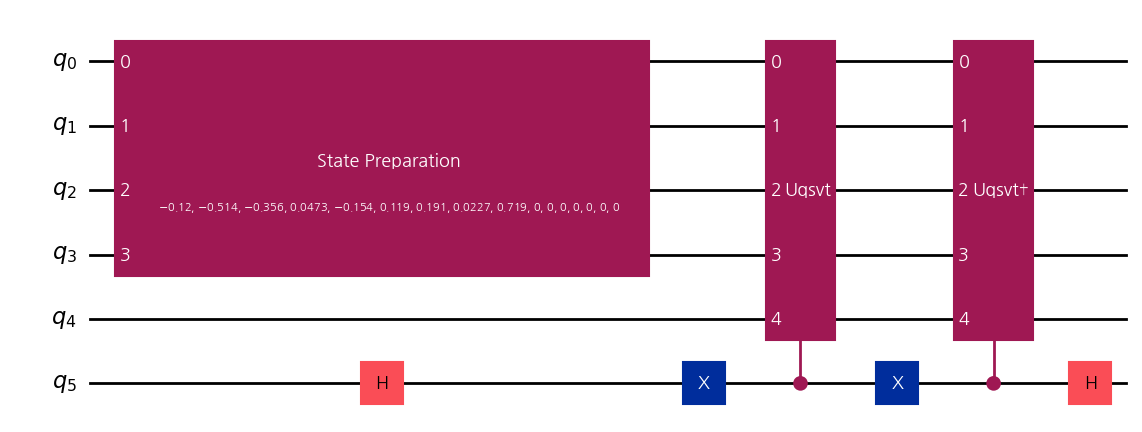

C:\Users\sungw\AppData\Local\Temp\ipykernel_47528\664349929.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  temp = np.linalg.lstsq(testcase.A, testcase.b)[0]


norm size: 101.68289230315737
[0.28372172+2.44092194e-11j 0.36031601+3.11263062e-11j
 0.39522172+3.38675852e-11j 0.41231956+3.54414839e-11j
 0.68078391+5.84668824e-11j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j]
ans (43.72295933118881+3.498669660065486e-09j)
norm size: 101.68289230315737
[0.28372172+2.44092194e-11j 0.36031601+3.11263062e-11j
 0.39522172+3.38675852e-11j 0.41231956+3.54414839e-11j
 0.68078391+5.84668824e-11j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j
 0.        -0.00000000e+00j 0.        -0.00000000e+00j]
ans (-27.25

In [387]:
error_magnitude = 0.02
shots_list = [1000000]
li = []
size_list = [4]
filename = "res_deg0.5.txt"

f = open(filename, "w")
for size in size_list:
    f.write(f"size: {size}\n")
    for i in range(1):
        print(f"{i}th run of size {size}")
        testcase = NLOStestcase(size, 50, 70, 30, 50)
        # add noise
        add_error(testcase, deg=0.5, dist=0.3)

        testcase.set_A(testcase.omega)
        testcase.set_b(testcase.omega)
        classic_sol = np.linalg.lstsq(testcase.A, testcase.b)[0]

        lambda_min = 1e-02

        first_hhl = HHLwithSWAP(testcase, 'x')
        second_hhl = HHLwithSWAP(
            testcase, 'y',
            hhl_state=first_hhl.hhl_state,
            norm_size=first_hhl.norm_size,
        )
        third_hhl = HHLwithSWAP(
            testcase, 'z',
            hhl_state=first_hhl.hhl_state,
            norm_size=first_hhl.norm_size,
        )

        hhl_had = [
            first_hhl,
            second_hhl,
            third_hhl
        ]
        transpiled_circ = [x.transpile(x.had_circ) for x in hhl_had]
                
        for shots in shots_list:
            results = [x.run(transpiled_circ[i], shots=shots) for i, x in enumerate(hhl_had)]
            print(results[0].data())
            f.write(f"shots: {shots}\n")
            for i, x in enumerate(['x', 'y', 'z']):
                f.write(f"NLOS {x}: {testcase.HV[i]}, Got: {np.abs(hhl_had[i].analyze(results[i]))}\n")
                f.write(f"{np.abs(hhl_had[i].analyze(results[i]) - testcase.HV[i])/np.abs(testcase.HV[i])}\n")
                li.append(np.abs(hhl_had[i].analyze(results[i]) - testcase.HV[i])/np.abs(testcase.HV[i]))
f.close()

In [325]:
import re
from typing import List, Dict, Any, Optional

def parse_res2(path: str) -> List[Dict[str, Any]]:
    """
    Parse the res2.txt file generated by your experiment script.

    Returns a list of records, each like:
        {
            'size': int,
            'run': Optional[int],   # 0,1,2,... if shots: lines exist, else None
            'shots': Optional[int],
            'axis': 'x' | 'y' | 'z',
            'true': float,
            'got': float,
            'rel_error': Optional[float],
        }
    """
    data: List[Dict[str, Any]] = []
    size: Optional[int] = None
    run_idx: int = -1
    shots: Optional[int] = None

    # Read and strip empty lines
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    i = 0
    while i < len(lines):
        line = lines[i]

        # ----- size: -----
        m_size = re.match(r"^size:\s*(\d+)", line)
        if m_size:
            size = int(m_size.group(1))
            run_idx = -1   # reset run index for new size
            shots = None
            i += 1
            continue

        # ----- shots: -----
        m_shots = re.match(r"^shots:\s*(\d+)", line)
        if m_shots:
            shots = int(m_shots.group(1))
            run_idx += 1   # new run for this size
            i += 1
            continue

        # ----- NLOS x/y/z line -----
        m_nlos = re.match(
            r"^NLOS\s+([xyz]):\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*,\s*Got:\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)$",
            line,
        )
        if m_nlos:
            axis = m_nlos.group(1)
            true_val = float(m_nlos.group(2))
            got_val = float(m_nlos.group(3))

            # Next line is supposed to be the relative error, but be defensive
            rel_error: Optional[float] = None
            if i + 1 < len(lines):
                try:
                    rel_error = float(lines[i + 1])
                    i += 2
                except ValueError:
                    # Not a numeric line; just move on
                    i += 1
            else:
                i += 1

            data.append(
                {
                    "size": size,
                    "run": run_idx if run_idx >= 0 else None,
                    "shots": shots,
                    "axis": axis,
                    "true": true_val,
                    "got": got_val,
                    "rel_error": rel_error,
                }
            )
            continue

        # Anything that doesn't match: just skip
        i += 1

    return data


In [327]:
from pathlib import Path

save_path = Path(r"C:\Users\sungw\Downloads\qiskitplay\res_deg0.5.txt")

# 폴더 없으면 생성
save_path.parent.mkdir(parents=True, exist_ok=True)

# 줄바꿈으로 저장
with save_path.open("w", encoding="utf-8", newline="\n") as f:
    for x in results:
        f.write(f"{x}\n")

## 5. Visualization

In [250]:
import koreanize_matplotlib
import matplotlib.pyplot as plt

In [328]:
import re
from typing import List, Dict, Any, Optional

def parse_res2(path: str) -> List[Dict[str, Any]]:
    """
    Parse the res2.txt file generated by your experiment script.

    Returns a list of records, each like:
        {
            'size': int,
            'run': Optional[int],   # 0,1,2,... if shots: lines exist, else None
            'shots': Optional[int],
            'axis': 'x' | 'y' | 'z',
            'true': float,
            'got': float,
            'rel_error': Optional[float],
        }
    """
    data: List[Dict[str, Any]] = []
    size: Optional[int] = None
    run_idx: int = -1
    shots: Optional[int] = None

    # Read and strip empty lines
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    i = 0
    while i < len(lines):
        line = lines[i]

        # ----- size: -----
        m_size = re.match(r"^size:\s*(\d+)", line)
        if m_size:
            size = int(m_size.group(1))
            run_idx = -1   # reset run index for new size
            shots = None
            i += 1
            continue

        # ----- shots: -----
        m_shots = re.match(r"^shots:\s*(\d+)", line)
        if m_shots:
            shots = int(m_shots.group(1))
            run_idx += 1   # new run for this size
            i += 1
            continue

        # ----- NLOS x/y/z line -----
        m_nlos = re.match(
            r"^NLOS\s+([xyz]):\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)\s*,\s*Got:\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)$",
            line,
        )
        if m_nlos:
            axis = m_nlos.group(1)
            true_val = float(m_nlos.group(2))
            got_val = float(m_nlos.group(3))

            # Next line is supposed to be the relative error, but be defensive
            rel_error: Optional[float] = None
            if i + 1 < len(lines):
                try:
                    rel_error = float(lines[i + 1])
                    i += 2
                except ValueError:
                    # Not a numeric line; just move on
                    i += 1
            else:
                i += 1

            data.append(
                {
                    "size": size,
                    "run": run_idx if run_idx >= 0 else None,
                    "shots": shots,
                    "axis": axis,
                    "true": true_val,
                    "got": got_val,
                    "rel_error": rel_error,
                }
            )
            continue

        # Anything that doesn't match: just skip
        i += 1

    return data

r = parse_res2("res_deg1.txt")

errs_16_100k = [
    [rr["true"],rr["got"]]
    for rr in r
    if rr["size"] == 4 and rr["shots"] == 1000000
    
]

print(errs_16_100k)


[[-30.954129236154007, 30.961945656867204], [26.5567756002825, 26.95655906252277], [32.99284891283057, 32.91968095615135], [-48.326627531462, 44.62248185116428], [16.17372669510722, 15.555841818712], [-22.59372171610571, 20.552884081232307], [-46.14204444577039, 33.943432942735384], [-42.93037459770797, 30.67902284091316], [0.14541547915656475, 0.19837040881201426], [28.69838941817387, 31.26386942227266], [20.878032551220198, 21.750389776243292], [49.235600160156906, 53.28603037481575], [35.15428447468173, 34.09011456417301], [-57.061174961937674, 54.10602221279689], [12.593653184445692, 11.429142982538131], [-1.0953989903197676, 1.0898366130041084], [-7.764007671768261, 7.086699851915256], [-58.75777581368513, 53.341574737797245], [-64.22261573215263, 60.6199678185821], [-1.3735884177756734, 1.210505268854225], [-1.1341075372044023, 0.6510279623809494], [41.72972555448098, 40.976208084279676], [41.827228997738914, 40.63664090880104], [-8.235122786838927, 8.081611458060879], [-6.917134

In [296]:
import matplotlib.pyplot as plt
import setuptools   # distutils 쉬임 활성화
import koreanize_matplotlib


In [341]:
from typing import Dict, List
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, List
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def plot_rel_error_by_size(data, shots_filter=None, max_rel_error=5.0):
    # 1. 선택적으로 shots 필터링
    if shots_filter is not None:
        records = [r for r in data if r["shots"] == shots_filter]
    else:
        records = data

    # 2. Group relative errors by size (ignore None, 컷오프 적용)
    grouped: Dict[int, List[float]] = defaultdict(list)
    for r in records:
        e = r["rel_error"]
        if e is None:
            continue
        if e >= max_rel_error:   # 상대오차 5 이상이면 버리기
            continue
        grouped[r["size"]].append(e)

    # 3. Compute mean and standard error for each size
    sizes = sorted(grouped.keys())
    means = []
    stds = []   # 여기서는 "표준오차"로 쓸 거임

    for s in sizes:
        arr = np.array(grouped[s], dtype=float)
        means.append(arr.mean())
        if len(arr) > 1:
            # sample std / sqrt(n) = standard error
            stds.append(arr.std(ddof=1) / np.sqrt(len(arr)))
        else:
            stds.append(0.0)
    
    # 디버그 출력용
    for s in sizes:
        arr = np.array(grouped[s], dtype=float)
        print("size", s, "n =", len(arr), "mean =", arr.mean())

    sizes = np.array(sizes, dtype=float)
    means = np.array(means)
    stds = np.array(stds)

    # 4. Plot with error bars
    fig, ax = plt.subplots()

    ax.errorbar(
        sizes,
        means,
        yerr=stds,
        fmt="o-",
        capsize=5,
    )
    ax.set_xlabel("Problem size")
    ax.set_ylim(0, 0.7)
    ax.set_ylabel("Relative error (mean ± 1 SE)")  # 표준오차 기준
    title = "Relative error vs. size"
    if shots_filter is not None:
        title += f" (shots={shots_filter})"
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()



In [356]:
from __future__ import annotations

from dataclasses import dataclass
from collections import defaultdict
from typing import List

import numpy as np
import matplotlib.pyplot as plt


@dataclass
class Record:
    size: int
    shots: int
    axis: str  # "x", "y", "z"
    true_val: float
    got_val: float
    rel_error: float | None


def parse_results(path: str) -> List[Record]:
    """Parse NLOS result file.

    Expected structure (repeats):

    size: 8
    shots: 10
    NLOS x: <true>, Got: <got>
    <rel_error>
    NLOS y: ...
    <rel_error>
    NLOS z: ...
    <rel_error>
    shots: 100
    ...

    Returns a list of Record objects.
    """
    records: List[Record] = []
    curr_size: int | None = None
    curr_shots: int | None = None

    with open(path, "r", encoding="utf-8") as f:
        # Strip blank lines
        lines = [ln.strip() for ln in f if ln.strip()]

    i = 0
    n = len(lines)

    while i < n:
        line = lines[i]

        # Update current size
        if line.startswith("size:"):
            try:
                curr_size = int(line.split(":", 1)[1].strip())
            except ValueError:
                curr_size = None
            i += 1
            continue

        # Update current shots
        if line.startswith("shots:"):
            try:
                curr_shots = int(line.split(":", 1)[1].strip())
            except ValueError:
                curr_shots = None
            i += 1
            continue

        # Parse NLOS line
        if line.startswith("NLOS"):
            # Example: "NLOS x: 39.9099..., Got: 61.0348..."
            header = line
            try:
                left, got_part = header.split("Got:")
                # 'NLOS x: 39.90..., '  and  '61.03...'
                axis = left.split()[1].rstrip(":")  # "x", "y", "z"
                true_str = left.split(":", 1)[1].split(",")[0].strip()
                got_str = got_part.strip()
                true_val = float(true_str)
                got_val = float(got_str)
            except Exception:
                # malformed line, skip
                i += 1
                continue

            # Next line should be relative error
            rel_error = None
            if i + 1 < n:
                rel_line = lines[i + 1]
                try:
                    rel_error = float(rel_line)
                except ValueError:
                    rel_error = None

            if curr_size is not None and curr_shots is not None:
                records.append(
                    Record(
                        size=curr_size,
                        shots=curr_shots,
                        axis=axis,
                        true_val=true_val,
                        got_val=got_val,
                        rel_error=rel_error,
                    )
                )

            i += 2
            continue

        # Anything else: skip
        i += 1

    return records


def plot_rel_error_by_shots(
    records: List[Record],
    size_filter: int | list[int] | None = None,
):
    """Group by shots and plot mean relative error with standard error bars.

    x-axis: shots (log scale)
    y-axis: average of rel_error over all NLOS components
    error bar: standard error of the mean (sample std / sqrt(n))

    size_filter:
        - None이면 모든 size 포함
        - int면 해당 size만 포함 (예: size_filter=16)
        - list[int]면 그 리스트에 포함된 size들만 포함 (예: [8, 16, 32])
    """
    # 0. 선택적으로 size 필터링
    if size_filter is not None:
        if isinstance(size_filter, int):
            allowed = {size_filter}
        else:
            # list[int] 같은 경우
            allowed = set(size_filter)
        records = [r for r in records if r.size in allowed]

    # 1. Group relative errors by shots
    grouped: dict[int, list[float]] = defaultdict(list)
    for r in records:
        if r.rel_error is not None:
            grouped[r.shots].append(r.rel_error)

    if not grouped:
        raise ValueError("No relative error data found to plot (after size filtering).")

    # 2. Compute mean and standard error for each shots value
    shots_vals = sorted(grouped.keys())
    means: list[float] = []
    ses: list[float] = []  # standard error

    for s in shots_vals:
        arr = np.array(grouped[s], dtype=float)
        means.append(arr.mean())
        if len(arr) > 1:
            std = arr.std(ddof=1)  # sample std
            se = std / np.sqrt(len(arr))
        else:
            se = 0.0
        ses.append(se)

    shots_arr = np.array(shots_vals, dtype=float)
    means_arr = np.array(means)
    ses_arr = np.array(ses)

    # 3. Plot
    fig, ax = plt.subplots()

    ax.errorbar(
        shots_arr,
        means_arr,
        yerr=ses_arr,
        fmt="o-",
        capsize=4,
    )

    ax.set_xscale("log")
    ax.set_xlabel("Shots")
    ax.set_ylabel("Mean relative error")

    title = "NLOS Relative Error vs Shots"
    if size_filter is not None:
        title += f" (size={size_filter})"
    ax.set_title(title)

    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    fig.tight_layout()
    print(shots_arr, means_arr)
    return fig, ax



[1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [0.79325851 0.27638351 0.10030583 0.06842675 0.07129829 0.07273942]


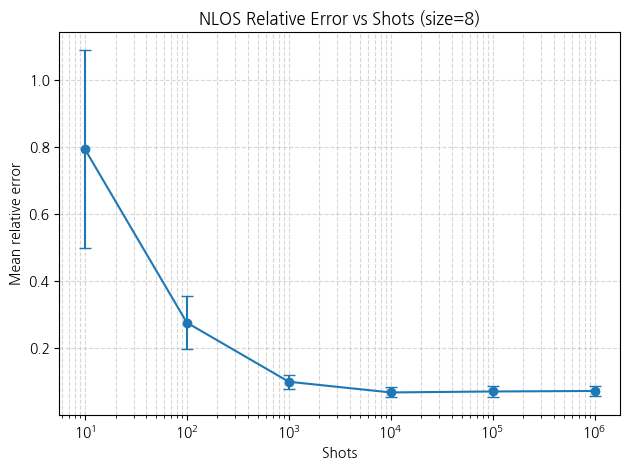

In [357]:
data = parse_results("res_deg1.txt")
fig, ax = plot_rel_error_by_shots(data, 8)
plt.show()

In [358]:
from collections import defaultdict
from typing import List, Dict, Any, Optional

import numpy as np
import matplotlib.pyplot as plt


def plot_rel_error_by_size_three(
    data1: List[Dict[str, Any]],
    data2: List[Dict[str, Any]],
    data3: List[Dict[str, Any]],
    label1: str = "run1",
    label2: str = "run2",
    label3: str = "run3",
    shots_filter: Optional[int] = None,
    max_rel_error: float = 5.0,
):
    """
    세 개의 결과셋을 받아서,
    size별 mean relative error + standard error 를 한 그래프에 그려줌.

    - x축: problem size
    - y축: mean rel_error
    - 에러바: standard error (sample std / sqrt(n))
    - shots_filter 가 주어지면 해당 shots 만 사용
    - rel_error >= max_rel_error 인 값은 버림
    """

    def _prepare(data: List[Dict[str, Any]]):
        # shots 필터링
        if shots_filter is not None:
            data = [r for r in data if r.get("shots") == shots_filter]

        # size 별로 rel_error 모으기 (None, max_rel_error 이상은 버림)
        grouped: Dict[int, List[float]] = defaultdict(list)
        for r in data:
            e = r.get("rel_error")
            if e is None:
                continue
            if e >= max_rel_error:
                continue
            size = r["size"]
            grouped[size].append(float(e))

        if not grouped:
            return None, None, None

        # size 정렬 + mean, SE 계산
        sizes = sorted(grouped.keys())
        means = []
        ses = []

        for s in sizes:
            arr = np.array(grouped[s], dtype=float)
            mean = arr.mean()
            if len(arr) > 1:
                std = arr.std(ddof=1)
                se = std / np.sqrt(len(arr))
            else:
                se = 0.0
            means.append(mean)
            ses.append(se)

        return np.array(sizes, dtype=float), np.array(means), np.array(ses)

    x1, m1, se1 = _prepare(data1)
    x2, m2, se2 = _prepare(data2)
    x3, m3, se3 = _prepare(data3)

    if x1 is None and x2 is None and x3 is None:
        raise ValueError("세 데이터셋 모두에서 유효한 rel_error가 없습니다.")

    fig, ax = plt.subplots()

    if x1 is not None:
        ax.errorbar(
            x1,
            m1,
            yerr=se1,
            fmt="o-",
            capsize=4,
            label=label1,
        )

    if x2 is not None:
        ax.errorbar(
            x2,
            m2,
            yerr=se2,
            fmt="s--",
            capsize=4,
            label=label2,
        )

    if x3 is not None:
        ax.errorbar(
            x3,
            m3,
            yerr=se3,
            fmt="^-.",
            capsize=4,
            label=label3,
        )

    ax.set_xlabel("Problem size")
    ax.set_ylabel("Mean relative error")
    title = f"Relative error vs Size"
    if shots_filter is not None:
        title += f"  (shots={shots_filter})"
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.5)
    ax.legend()
    print(x1, m1)
    print(x2, m2)
    print(x3, m3)

    fig.tight_layout()
    return fig, ax


[ 2.  3.  4.  5.  6.  7.  8. 12. 16.] [0.59146623 0.25910343 0.20563304 0.0888971  0.09452617 0.08767546
 0.07273942 0.07216119 0.03560606]
[ 2.  3.  4.  5.  6.  7.  8. 12. 16.] [0.33129372 0.22732537 0.20725847 0.26768587 0.16272628 0.13484036
 0.1013483  0.09183058 0.06779501]
[ 2.  3.  4.  5.  6.  7.  8. 12. 16.] [0.28883439 0.11001862 0.08130285 0.09368868 0.09367221 0.07165505
 0.07687134 0.07940971 0.04673156]


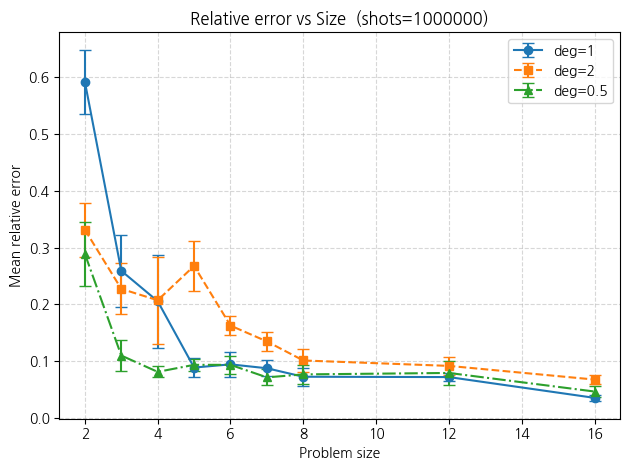

In [359]:
res_deg1  = parse_res2("res_deg1.txt")
res_deg2  = parse_res2("res_deg2.txt")
res_deg3 = parse_res2("res_deg0.5.txt")

# shots = 1,000,000일 때 size별 비교
fig, ax = plot_rel_error_by_size_three(
    res_deg1,
    res_deg2,
    res_deg3,
    label1="deg=1",
    label2="deg=2",
    label3="deg=0.5",
    shots_filter=1_000_000,
)
plt.show()
